In [1]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [3]:
# Directorio donde están los archivos KML
path_kml = r'C:/Documents/OneDrive - Ingenio Azucarero Guabira S.A/UTEA_2023/PROYECTO AREA LIBERACION/SEGUIMIENTO2/SEMANA_42/LOGS_21-10-2023/'
contenido = os.listdir(path_kml)
len(contenido)

57

In [4]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [5]:
# dic con la geometria y el file_name
data_lineas = {
    'geometry': lineas,
    'nombre': file_name
}

In [6]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)

In [14]:
gdf_lineas.crs = "EPSG:4326"

In [15]:
gdf_lineas = gdf_lineas.to_crs(epsg=32720)

<Axes: >

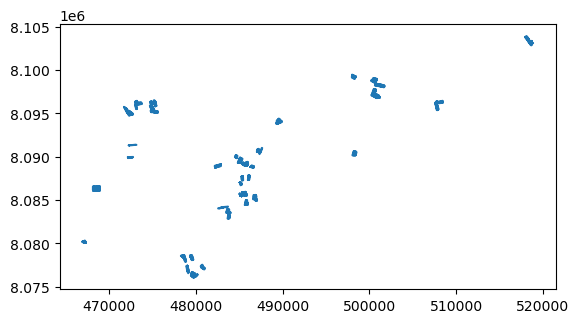

In [16]:
gdf_lineas.plot()

In [17]:
len(gdf_lineas)

57

In [18]:
gdf_lineas.to_file('capa_logs', driver="ESRI Shapefile")